## 1. RS, MaxSum, Exact algo

### RS

In [136]:
R_rs = 0.01:0.01:0.99
D_rs = [0.4546474073128681,0.43565049932361133,0.42092765046912317,0.40839439222208573,0.3972457420215144,0.3870702443196218,0.3776242651788484,0.36874955806591975,0.3603365352601175,0.3523056385673838,0.34459697668198624,0.33716414626734653,0.3299703418625086,0.3229857971761951,0.31618604029437997,0.30955066735206993,0.30306245811343413,0.2967067238049428,0.2904708168067388,0.2843437556958753,0.2783159341345032,0.27237889177802405,0.26652513178257226,0.2607479738209666,0.2550414345013817,0.24940012917780852,0.2438191906350483,0.2382942012118009,0.2328211357178961,0.22739631308980668,0.22201635516998064,0.21667815133009227,0.211378827914124,0.20688352899753953,0.20278317659003975,0.19868817793711935,0.1945975994415784,0.19051056552023182,0.18642625421128822,0.18234389327612,0.17826275673045133,0.17418216174918932,0.17010146589683228,0.16602006464188257,0.16193738911916555,0.15785290410864755,0.1537661062033548,0.14967652214243293,0.1455837072883871,0.14148724423013948,0.137998366107847,0.13448740638286893,0.13095421069018287,0.12739865696194796,0.12382065470933767,0.12022014422138577,0.11659709568295457,0.1129515082152911,0.10928340884389087,0.10559285139949881,0.10231362606715677,0.0989986151678956,0.09564794614910743,0.0922617930523803,0.0888403753926773,0.08538395674018595,0.0820151560863665,0.0788488704133426,0.07563678673548502,0.07237911796887381,0.06907615625262697,0.06591319349557895,0.06283584277258297,0.05970319879491964,0.056515457092013055,0.053562785457060835,0.05054512262289507,0.04752198628196386,0.04463641809759822,0.04167585667427448,0.0388827836051418,0.03604608454052277,0.033304960430999175,0.03060809220840449,0.027952952887639493,0.025359146185103376,0.022832861932172044,0.020370784947590925,0.017979055383501308,0.015666129177374533,0.013449978144655372,0.0113201258591068,0.009302254807509736,0.007397829094439923,0.0056264302423451595,0.004010648891537405,0.002577264143732827,0.0013672330158682189,0.0004509986577261871];

In [574]:
include("../code/bp_full.jl")
include("../code/optimal_cycle.jl")
include("../code/rs.jl")
include("../code/bp.jl")

cb_decimation (generic function with 2 methods)

### Exact algo

In [138]:
function f(n, Rs, navg_exact, Ks, Λ, D_exact, verbose=true)
    for i in eachindex(Rs)
        m = round(Int,n*(1-Rs[i])); nedges = 2n
        Threads.@threads for j in 1:navg_exact
            H = permutedims(ldpc_matrix(n, m, nedges, Λ, Ks[i]))
            s = rand((-1,1),n)
            ovl, _, _ = findsol(H, s, verbose=false)
            D_exact[i][j] = (1-ovl)/2
        end
        verbose && println("Rate $(Rs[i]) done")
        flush(stdout)
    end
    mean.(D_exact)
end    

f (generic function with 2 methods)

In [139]:
n = 1200
navg_exact = 500
D_exact = [zeros(navg_exact) for _ in Rs]
D_exact_avg = f(n, Rs, navg_exact, Ks, Λ, D_exact);

Rate 0.15 done
Rate 0.2 done
Rate 0.25 done
Rate 0.3 done
Rate 0.35 done
Rate 0.4 done
Rate 0.45 done
Rate 0.5 done
Rate 0.55 done
Rate 0.6 done
Rate 0.65 done
Rate 0.7 done


### MaxSum

In [573]:
function ff(n, Rs, navg, Ks, Λ, D_ms, D_exact; verbose=true, maxiter=10^2, kw...)
    efield = [(.0,.0) for _ in 1:n]
    s = zeros(Int, n)
    for i in eachindex(Rs)
        m = round(Int,n*(1-Rs[i])); nedges = 2n
        vars = rand(1:n, n*2÷3); factors=rand(1:m-1, m*2÷3)
        for j in 1:navg
            Ht = ldpc_matrix(n, m, nedges, Λ, Ks[i]; accept_multi_edges=false)[:,1:end-1]
            H = permutedims(Ht)
            s .= rand((-1.,1.),n)
            efield .= [(si,-si).+ 1e-5.*(randn(),randn()) for si in s]
            ms = BPFull(H, efield)
            ε, iters = iteration_ms!(ms, maxiter=maxiter;
                vars=vars, factors=factors, kw...)
            verbose && @show nunsat, ovl, dist = performance(ms, s)
            flush(stdout)
            if nunsat!=0
                B,indep = findbasis(H, Ht)
                x = argmax.(ms.belief) .== 2
                σ = fix_indep!(x, B, indep)   
                D_ms[i][j] = distortion(σ,s)
                verbose && @show D_ms[i][j], dist
            else
                D_ms[i][j] = dist
            end
            ovl, _, _ = findsol(H, s, verbose=false)
            D_exact[i][j] = (1-ovl)/2
        end
        println("Rate $(Rs[i]) done")
        flush(stdout)
    end
    mean.(D_ms), mean.(D_exact)
end

ff (generic function with 1 method)

In [598]:
Rs = 0.15:0.05:0.7
Λ = [0, 1]
Ks = [zeros(0) for _ in Rs]
for (i,R) in enumerate(Rs)
    α = 1-R
    k = floor(Int, 2/α)
    s = k+1-2/α
    K = [fill(0,k-1); s; 1-s]
    Ks[i] = K ./ sum(K)
end

In [600]:
n = 1800
navg = 20
D_ms = [zeros(navg) for _ in Rs]
D_exact = [zeros(navg) for _ in Rs]

D_ms_avg, D_exact_avg = ff(n, Rs, navg, Ks, Λ, D_ms, D_exact, maxiter=10^3, rein=1e-4, verbose=true);

(nunsat, ovl, dist) = performance(ms, s) = (2, 0.3733333333333333, 0.31333333333333335)
((D_ms[i])[j], dist) = (0.3244444444444444, 0.31333333333333335)
(nunsat, ovl, dist) = performance(ms, s) = (1, 0.37111111111111106, 0.31444444444444447)
((D_ms[i])[j], dist) = (0.31666666666666665, 0.31444444444444447)
(nunsat, ovl, dist) = performance(ms, s) = (3, 0.3733333333333333, 0.31333333333333335)
((D_ms[i])[j], dist) = (0.3194444444444444, 0.31333333333333335)
(nunsat, ovl, dist) = performance(ms, s) = (0, 0.39222222222222225, 0.3038888888888889)
(nunsat, ovl, dist) = performance(ms, s) = (1, 0.3766666666666667, 0.31166666666666665)
((D_ms[i])[j], dist) = (0.3138888888888889, 0.31166666666666665)
(nunsat, ovl, dist) = performance(ms, s) = (2, 0.3666666666666667, 0.31666666666666665)
((D_ms[i])[j], dist) = (0.32222222222222224, 0.31666666666666665)
(nunsat, ovl, dist) = performance(ms, s) = (4, 0.3655555555555555, 0.31722222222222224)
((D_ms[i])[j], dist) = (0.32166666666666666, 0.317222222

((D_ms[i])[j], dist) = (0.26722222222222225, 0.26055555555555554)
Rate 0.25 done
(nunsat, ovl, dist) = performance(ms, s) = (6, 0.5466666666666666, 0.22666666666666666)
((D_ms[i])[j], dist) = (0.23944444444444443, 0.22666666666666666)
(nunsat, ovl, dist) = performance(ms, s) = (1, 0.5511111111111111, 0.22444444444444445)
((D_ms[i])[j], dist) = (0.22555555555555556, 0.22444444444444445)
(nunsat, ovl, dist) = performance(ms, s) = (0, 0.5244444444444445, 0.23777777777777778)
(nunsat, ovl, dist) = performance(ms, s) = (0, 0.5411111111111111, 0.22944444444444445)
(nunsat, ovl, dist) = performance(ms, s) = (3, 0.5566666666666666, 0.22166666666666668)
((D_ms[i])[j], dist) = (0.22722222222222221, 0.22166666666666668)
(nunsat, ovl, dist) = performance(ms, s) = (4, 0.54, 0.23)
((D_ms[i])[j], dist) = (0.24, 0.23)
(nunsat, ovl, dist) = performance(ms, s) = (3, 0.5522222222222222, 0.2238888888888889)
((D_ms[i])[j], dist) = (0.23166666666666666, 0.2238888888888889)
(nunsat, ovl, dist) = performance(

(nunsat, ovl, dist) = performance(ms, s) = (4, 0.6766666666666667, 0.16166666666666665)
((D_ms[i])[j], dist) = (0.16666666666666666, 0.16166666666666665)
(nunsat, ovl, dist) = performance(ms, s) = (1, 0.6722222222222223, 0.1638888888888889)
((D_ms[i])[j], dist) = (0.16722222222222222, 0.1638888888888889)
(nunsat, ovl, dist) = performance(ms, s) = (1, 0.6799999999999999, 0.16)
((D_ms[i])[j], dist) = (0.1622222222222222, 0.16)
(nunsat, ovl, dist) = performance(ms, s) = (1, 0.6666666666666667, 0.16666666666666666)
((D_ms[i])[j], dist) = (0.16722222222222222, 0.16666666666666666)
(nunsat, ovl, dist) = performance(ms, s) = (1, 0.6822222222222223, 0.15888888888888889)
((D_ms[i])[j], dist) = (0.16111111111111112, 0.15888888888888889)
(nunsat, ovl, dist) = performance(ms, s) = (0, 0.6766666666666667, 0.16166666666666665)
(nunsat, ovl, dist) = performance(ms, s) = (2, 0.6688888888888889, 0.16555555555555557)
((D_ms[i])[j], dist) = (0.17, 0.16555555555555557)
(nunsat, ovl, dist) = performance(ms

((D_ms[i])[j], dist) = (0.12, 0.105)
(nunsat, ovl, dist) = performance(ms, s) = (4, 0.7855555555555556, 0.10722222222222222)
((D_ms[i])[j], dist) = (0.11388888888888889, 0.10722222222222222)
(nunsat, ovl, dist) = performance(ms, s) = (0, 0.7866666666666666, 0.10666666666666667)
(nunsat, ovl, dist) = performance(ms, s) = (5, 0.7755555555555556, 0.11222222222222222)
((D_ms[i])[j], dist) = (0.12, 0.11222222222222222)
(nunsat, ovl, dist) = performance(ms, s) = (6, 0.7988888888888889, 0.10055555555555555)
((D_ms[i])[j], dist) = (0.11333333333333333, 0.10055555555555555)
(nunsat, ovl, dist) = performance(ms, s) = (6, 0.7788888888888889, 0.11055555555555556)
((D_ms[i])[j], dist) = (0.12, 0.11055555555555556)
(nunsat, ovl, dist) = performance(ms, s) = (4, 0.7866666666666666, 0.10666666666666667)
((D_ms[i])[j], dist) = (0.11222222222222222, 0.10666666666666667)
(nunsat, ovl, dist) = performance(ms, s) = (2, 0.7911111111111111, 0.10444444444444445)
((D_ms[i])[j], dist) = (0.10777777777777778, 0.

((D_ms[i])[j], dist) = (0.07444444444444444, 0.07222222222222222)
Rate 0.7 done


### Plot

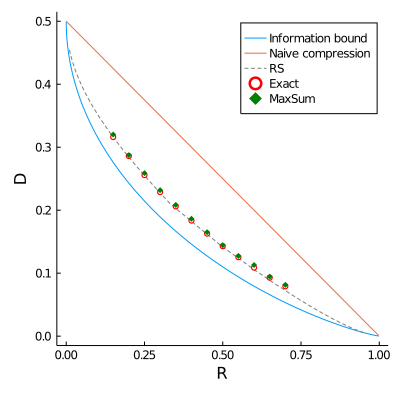

In [734]:
pl1 = plot_rdb(; f30=false, f3=false)
Plots.default(ms=3, msw=0, fontfamily="sans-serif", grid=false)
plot!(pl1, R_rs[1:end-3], D_rs[1:end-3], label="RS", line=:dash, c=:gray)
scatter!(pl1, Rs, D_exact_avg, label="Exact", m=:circle, c=:white, ms=3, msc=:red, msw=1.5)
scatter!(pl1, Rs, D_ms_avg, label="MaxSum", c=:green, m=:diamond)
plot!(pl1, size=(400,400))

In [703]:
savefig("rdb_degree2.pdf")

## 2. BP + decimation

In [704]:
include("../code/bp_full.jl")
using Base.Threads

In [743]:
function bp_dec(f1, f2, n, H; Tmax=1, fair_decimation=true)
    f3 = 1 - f1 -f2
    Lambda = [f1,f2,f3]
    K = [0,0,1]
    nedges = Int(round(n*sum(i*l for (i,l) in pairs(Lambda)), digits=10))
    m = Int(nedges/3)
    s = rand((-1,1), n)
    efield = [(exp(ss*H),exp(-ss*H)) for ss in s]
    bp = bp_full(n, m, nedges, Lambda, K, efield)
    B, indep = findbasis_slow(Array(bp.H))
    R = size(B,2)/n
    dist = decimate!(bp, efield, indep, s, B, maxiter=10^3, Tmax=Tmax, tol=1e-5, 
        fair_decimation=fair_decimation) 
    dist, bp, R
end

bp_dec (generic function with 1 method)

In [721]:
f1 = 1/100
n = 1800
H = 3
f2s = [.35, .4, .45, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95]
navg = 15
D_bp = [zeros(navg) for f2 in f2s]
R_bp = zeros(length(f2s))
for i in eachindex(f2s)
    println("#### Rate $i of $(length(f2s))")
   @threads for j in 1:navg
        D_bp[i][j], bp, R_bp[i] = bp_dec(f1, f2s[i], n, H, Tmax=25)
    end
    flush(stdout)
end

#### Rate 1 of 13
Trial 1 of 25: 372 unsat. Dist = 0.456
Trial 1 of 25: 338 unsat. Dist = 0.439
Trial 1 of 25: 383 unsat. Dist = 0.453
Trial 1 of 25: 380 unsat. Dist = 0.445
Trial 1 of 25: 402 unsat. Dist = 0.451
Trial 1 of 25: 448 unsat. Dist = 0.443
Trial 1 of 25: 347 unsat. Dist = 0.429
Trial 1 of 25: 355 unsat. Dist = 0.454
Trial 2 of 25: 402 unsat. Dist = 0.446
Trial 2 of 25: 399 unsat. Dist = 0.429
Trial 2 of 25: 355 unsat. Dist = 0.447
Trial 2 of 25: 385 unsat. Dist = 0.45
Trial 2 of 25: 363 unsat. Dist = 0.437
Trial 2 of 25: 373 unsat. Dist = 0.421
Trial 2 of 25: 378 unsat. Dist = 0.436
Trial 2 of 25: 364 unsat. Dist = 0.446
Trial 3 of 25: 351 unsat. Dist = 0.442
Trial 3 of 25: 339 unsat. Dist = 0.436
Trial 3 of 25: 378 unsat. Dist = 0.447
Trial 3 of 25: 372 unsat. Dist = 0.457
Trial 3 of 25: 412 unsat. Dist = 0.456
Trial 3 of 25: 380 unsat. Dist = 0.454
Trial 3 of 25: 404 unsat. Dist = 0.447
Trial 3 of 25: 369 unsat. Dist = 0.444
Trial 4 of 25: 362 unsat. Dist = 0.443
Trial 4 

Trial 10 of 25: 396 unsat. Dist = 0.461
Trial 10 of 25: 387 unsat. Dist = 0.443
Trial 10 of 25: 407 unsat. Dist = 0.448
Trial 10 of 25: 357 unsat. Dist = 0.457
Trial 10 of 25: 303 unsat. Dist = 0.447
Trial 11 of 25: 368 unsat. Dist = 0.443
Trial 11 of 25: 397 unsat. Dist = 0.441
Trial 11 of 25: 386 unsat. Dist = 0.469
Trial 11 of 25: 375 unsat. Dist = 0.433
Trial 11 of 25: 400 unsat. Dist = 0.447
Trial 11 of 25: 394 unsat. Dist = 0.456
Trial 11 of 25: 387 unsat. Dist = 0.436
Trial 12 of 25: 390 unsat. Dist = 0.434
Trial 12 of 25: 384 unsat. Dist = 0.438
Trial 12 of 25: 347 unsat. Dist = 0.442
Trial 12 of 25: 360 unsat. Dist = 0.429
Trial 12 of 25: 400 unsat. Dist = 0.44
Trial 12 of 25: 360 unsat. Dist = 0.419
Trial 12 of 25: 425 unsat. Dist = 0.421
Trial 13 of 25: 344 unsat. Dist = 0.445
Trial 13 of 25: 366 unsat. Dist = 0.466
Trial 13 of 25: 379 unsat. Dist = 0.443
Trial 13 of 25: 415 unsat. Dist = 0.434
Trial 13 of 25: 325 unsat. Dist = 0.44
Trial 13 of 25: 352 unsat. Dist = 0.458
Tr

Trial 10 of 25: 340 unsat. Dist = 0.421
Trial 10 of 25: 349 unsat. Dist = 0.449
Trial 10 of 25: 349 unsat. Dist = 0.446
Trial 10 of 25: 397 unsat. Dist = 0.443
Trial 10 of 25: 355 unsat. Dist = 0.434
Trial 11 of 25: 316 unsat. Dist = 0.432
Trial 11 of 25: 352 unsat. Dist = 0.423
Trial 11 of 25: 354 unsat. Dist = 0.473
Trial 11 of 25: 393 unsat. Dist = 0.455
Trial 11 of 25: 332 unsat. Dist = 0.43
Trial 11 of 25: 336 unsat. Dist = 0.428
Trial 11 of 25: 348 unsat. Dist = 0.443
Trial 12 of 25: 382 unsat. Dist = 0.463
Trial 12 of 25: 384 unsat. Dist = 0.451
Trial 12 of 25: 338 unsat. Dist = 0.442
Trial 12 of 25: 387 unsat. Dist = 0.451
Trial 12 of 25: 344 unsat. Dist = 0.456
Trial 12 of 25: 339 unsat. Dist = 0.446
Trial 12 of 25: 333 unsat. Dist = 0.454
Trial 13 of 25: 333 unsat. Dist = 0.422
Trial 13 of 25: 296 unsat. Dist = 0.447
Trial 13 of 25: 368 unsat. Dist = 0.453
Trial 13 of 25: 401 unsat. Dist = 0.444
Trial 13 of 25: 314 unsat. Dist = 0.421
Trial 13 of 25: 371 unsat. Dist = 0.451
T

Trial 10 of 25: 298 unsat. Dist = 0.437
Trial 10 of 25: 288 unsat. Dist = 0.397
Trial 10 of 25: 259 unsat. Dist = 0.444
Trial 10 of 25: 292 unsat. Dist = 0.428
Trial 10 of 25: 289 unsat. Dist = 0.461
Trial 11 of 25: 305 unsat. Dist = 0.412
Trial 11 of 25: 227 unsat. Dist = 0.431
Trial 11 of 25: 287 unsat. Dist = 0.418
Trial 11 of 25: 281 unsat. Dist = 0.431
Trial 11 of 25: 290 unsat. Dist = 0.437
Trial 11 of 25: 287 unsat. Dist = 0.423
Trial 11 of 25: 291 unsat. Dist = 0.444
Trial 12 of 25: 291 unsat. Dist = 0.424
Trial 12 of 25: 302 unsat. Dist = 0.423
Trial 12 of 25: 260 unsat. Dist = 0.425
Trial 12 of 25: 253 unsat. Dist = 0.442
Trial 12 of 25: 284 unsat. Dist = 0.424
Trial 12 of 25: 285 unsat. Dist = 0.416
Trial 12 of 25: 268 unsat. Dist = 0.458
Trial 13 of 25: 275 unsat. Dist = 0.423
Trial 13 of 25: 252 unsat. Dist = 0.417
Trial 13 of 25: 271 unsat. Dist = 0.453
Trial 13 of 25: 326 unsat. Dist = 0.434
Trial 13 of 25: 271 unsat. Dist = 0.436
Trial 13 of 25: 287 unsat. Dist = 0.414


Trial 10 of 25: 286 unsat. Dist = 0.423
Trial 10 of 25: 240 unsat. Dist = 0.433
Trial 10 of 25: 201 unsat. Dist = 0.411
Trial 10 of 25: 220 unsat. Dist = 0.43
Trial 10 of 25: 282 unsat. Dist = 0.413
Trial 11 of 25: 243 unsat. Dist = 0.382
Trial 11 of 25: 251 unsat. Dist = 0.438
Trial 11 of 25: 288 unsat. Dist = 0.429
Trial 11 of 25: 342 unsat. Dist = 0.408
Trial 11 of 25: 270 unsat. Dist = 0.399
Trial 11 of 25: 220 unsat. Dist = 0.431
Trial 12 of 25: 220 unsat. Dist = 0.398
Trial 11 of 25: 252 unsat. Dist = 0.411
Trial 12 of 25: 230 unsat. Dist = 0.416
Trial 12 of 25: 255 unsat. Dist = 0.42
Trial 12 of 25: 256 unsat. Dist = 0.419
Trial 12 of 25: 253 unsat. Dist = 0.396
Trial 12 of 25: 283 unsat. Dist = 0.411
Trial 13 of 25: 262 unsat. Dist = 0.409
Trial 12 of 25: 281 unsat. Dist = 0.426
Trial 13 of 25: 233 unsat. Dist = 0.436
Trial 13 of 25: 261 unsat. Dist = 0.417
Trial 13 of 25: 219 unsat. Dist = 0.427
Trial 13 of 25: 252 unsat. Dist = 0.408
Trial 13 of 25: 219 unsat. Dist = 0.402
Tr

Trial 10 of 25: 174 unsat. Dist = 0.396
Trial 11 of 25: 244 unsat. Dist = 0.408
Trial 11 of 25: 141 unsat. Dist = 0.391
Trial 11 of 25: 211 unsat. Dist = 0.398
Trial 11 of 25: 167 unsat. Dist = 0.422
Trial 11 of 25: 213 unsat. Dist = 0.409
Trial 11 of 25: 229 unsat. Dist = 0.396
Trial 11 of 25: 168 unsat. Dist = 0.395
Trial 12 of 25: 0 unsat. Dist = 0.514
Trial 12 of 25: 241 unsat. Dist = 0.399
Trial 12 of 25: 0 unsat. Dist = 0.507
Trial 12 of 25: 0 unsat. Dist = 0.495
Trial 12 of 25: 0 unsat. Dist = 0.496
Trial 12 of 25: 217 unsat. Dist = 0.392
Trial 12 of 25: 276 unsat. Dist = 0.41
Trial 13 of 25: 230 unsat. Dist = 0.423
Trial 13 of 25: 184 unsat. Dist = 0.394
Trial 13 of 25: 235 unsat. Dist = 0.398
Trial 13 of 25: 0 unsat. Dist = 0.496
Trial 13 of 25: 192 unsat. Dist = 0.391
Trial 13 of 25: 256 unsat. Dist = 0.403
Trial 13 of 25: 227 unsat. Dist = 0.41
Trial 14 of 25: 261 unsat. Dist = 0.399
Trial 14 of 25: 0 unsat. Dist = 0.495
Trial 14 of 25: 203 unsat. Dist = 0.399
Trial 14 of 25

Trial 8 of 25: 0 unsat. Dist = 0.503
Trial 12 of 25: 143 unsat. Dist = 0.383
Trial 12 of 25: 165 unsat. Dist = 0.39
Trial 10 of 25: 0 unsat. Dist = 0.496
Trial 12 of 25: 0 unsat. Dist = 0.271
Trial 11 of 25: 154 unsat. Dist = 0.382
Trial 12 of 25: 0 unsat. Dist = 0.267
Trial 13 of 25: 0 unsat. Dist = 0.259
Trial 9 of 25: 0 unsat. Dist = 0.503
Trial 13 of 25: 0 unsat. Dist = 0.48
Trial 13 of 25: 0 unsat. Dist = 0.492
Trial 11 of 25: 174 unsat. Dist = 0.388
Trial 13 of 25: 0 unsat. Dist = 0.498
Trial 12 of 25: 184 unsat. Dist = 0.382
Trial 14 of 25: 0 unsat. Dist = 0.508
Trial 10 of 25: 0 unsat. Dist = 0.269
Trial 14 of 25: 237 unsat. Dist = 0.374
Trial 14 of 25: 0 unsat. Dist = 0.492
Trial 12 of 25: 0 unsat. Dist = 0.496
Trial 15 of 25: 0 unsat. Dist = 0.508
Trial 14 of 25: 0 unsat. Dist = 0.498
Trial 13 of 25: 0 unsat. Dist = 0.493
Trial 11 of 25: 134 unsat. Dist = 0.404
Trial 15 of 25: 0 unsat. Dist = 0.48
Trial 15 of 25: 141 unsat. Dist = 0.377
Trial 16 of 25: 0 unsat. Dist = 0.258
T

Trial 11 of 25: 0 unsat. Dist = 0.528
Trial 11 of 25: 0 unsat. Dist = 0.491
Trial 11 of 25: 0 unsat. Dist = 0.485
Trial 10 of 25: 0 unsat. Dist = 0.517
Trial 12 of 25: 1 unsat. Dist = 0.352
Trial 12 of 25: 0 unsat. Dist = 0.496
Trial 12 of 25: 0 unsat. Dist = 0.518
Trial 12 of 25: 0 unsat. Dist = 0.491
Trial 12 of 25: 0 unsat. Dist = 0.258
Trial 12 of 25: 0 unsat. Dist = 0.485
Trial 11 of 25: 107 unsat. Dist = 0.377
Trial 13 of 25: 0 unsat. Dist = 0.257
Trial 13 of 25: 0 unsat. Dist = 0.259
Trial 13 of 25: 0 unsat. Dist = 0.518
Trial 13 of 25: 0 unsat. Dist = 0.491
Trial 13 of 25: 0 unsat. Dist = 0.528
Trial 13 of 25: 145 unsat. Dist = 0.349
Trial 12 of 25: 0 unsat. Dist = 0.517
Trial 14 of 25: 0 unsat. Dist = 0.507
Trial 14 of 25: 0 unsat. Dist = 0.263
Trial 14 of 25: 0 unsat. Dist = 0.491
Trial 14 of 25: 0 unsat. Dist = 0.518
Trial 14 of 25: 1 unsat. Dist = 0.262
Trial 14 of 25: 1 unsat. Dist = 0.363
Trial 13 of 25: 0 unsat. Dist = 0.259
Trial 15 of 25: 0 unsat. Dist = 0.507
Trial 15

Trial 11 of 25: 0 unsat. Dist = 0.239
Trial 12 of 25: 0 unsat. Dist = 0.251
Trial 12 of 25: 0 unsat. Dist = 0.246
Trial 12 of 25: 0 unsat. Dist = 0.499
Trial 12 of 25: 0 unsat. Dist = 0.477
Trial 13 of 25: 0 unsat. Dist = 0.243
Trial 12 of 25: 0 unsat. Dist = 0.247
Trial 12 of 25: 0 unsat. Dist = 0.508
Trial 13 of 25: 2 unsat. Dist = 0.323
Trial 13 of 25: 0 unsat. Dist = 0.245
Trial 13 of 25: 0 unsat. Dist = 0.256
Trial 14 of 25: 0 unsat. Dist = 0.511
Trial 13 of 25: 0 unsat. Dist = 0.477
Trial 13 of 25: 0 unsat. Dist = 0.5
Trial 14 of 25: 0 unsat. Dist = 0.243
Trial 13 of 25: 0 unsat. Dist = 0.243
Trial 14 of 25: 0 unsat. Dist = 0.247
Trial 14 of 25: 0 unsat. Dist = 0.499
Trial 15 of 25: 0 unsat. Dist = 0.246
Trial 14 of 25: 0 unsat. Dist = 0.477
Trial 14 of 25: 0 unsat. Dist = 0.246
Trial 15 of 25: 1 unsat. Dist = 0.356
Trial 14 of 25: 0 unsat. Dist = 0.242
Trial 15 of 25: 0 unsat. Dist = 0.482
Trial 15 of 25: 0 unsat. Dist = 0.249
Trial 15 of 25: 5 unsat. Dist = 0.241
Trial 16 of 25

Trial 12 of 25: 0 unsat. Dist = 0.242
Trial 11 of 25: 0 unsat. Dist = 0.5
Trial 11 of 25: 0 unsat. Dist = 0.522
Trial 12 of 25: 0 unsat. Dist = 0.241
Trial 12 of 25: 1 unsat. Dist = 0.339
Trial 12 of 25: 5 unsat. Dist = 0.244
Trial 13 of 25: 0 unsat. Dist = 0.24
Trial 12 of 25: 0 unsat. Dist = 0.519
Trial 12 of 25: 0 unsat. Dist = 0.232
Trial 12 of 25: 0 unsat. Dist = 0.241
Trial 13 of 25: 0 unsat. Dist = 0.236
Trial 13 of 25: 0 unsat. Dist = 0.243
Trial 13 of 25: 1 unsat. Dist = 0.333
Trial 14 of 25: 0 unsat. Dist = 0.241
Trial 13 of 25: 0 unsat. Dist = 0.519
Trial 13 of 25: 0 unsat. Dist = 0.237
Trial 13 of 25: 0 unsat. Dist = 0.241
Trial 14 of 25: 1 unsat. Dist = 0.33
Trial 14 of 25: 0 unsat. Dist = 0.519
Trial 14 of 25: 0 unsat. Dist = 0.247
Trial 15 of 25: 0 unsat. Dist = 0.244
Trial 14 of 25: 0 unsat. Dist = 0.519
Trial 14 of 25: 8 unsat. Dist = 0.334
Trial 14 of 25: 0 unsat. Dist = 0.239
Trial 15 of 25: 0 unsat. Dist = 0.239
Trial 15 of 25: 0 unsat. Dist = 0.238
Trial 15 of 25: 

Trial 11 of 25: 3 unsat. Dist = 0.321
Trial 12 of 25: 0 unsat. Dist = 0.492
Trial 11 of 25: 0 unsat. Dist = 0.227
Trial 11 of 25: 3 unsat. Dist = 0.251
Trial 12 of 25: 6 unsat. Dist = 0.244
Trial 12 of 25: 1 unsat. Dist = 0.252
Trial 11 of 25: 0 unsat. Dist = 0.497
Trial 12 of 25: 1 unsat. Dist = 0.341
Trial 13 of 25: 2 unsat. Dist = 0.254
Trial 12 of 25: 0 unsat. Dist = 0.227
Trial 12 of 25: 0 unsat. Dist = 0.501
Trial 13 of 25: 0 unsat. Dist = 0.231
Trial 13 of 25: 0 unsat. Dist = 0.517
Trial 12 of 25: 2 unsat. Dist = 0.328
Trial 13 of 25: 0 unsat. Dist = 0.237
Trial 13 of 25: 0 unsat. Dist = 0.236
Trial 14 of 25: 0 unsat. Dist = 0.492
Trial 13 of 25: 0 unsat. Dist = 0.501
Trial 14 of 25: 0 unsat. Dist = 0.232
Trial 13 of 25: 1 unsat. Dist = 0.231
Trial 14 of 25: 0 unsat. Dist = 0.236
Trial 14 of 25: 0 unsat. Dist = 0.499
Trial 14 of 25: 0 unsat. Dist = 0.229
Trial 15 of 25: 1 unsat. Dist = 0.245
Trial 14 of 25: 0 unsat. Dist = 0.501
Trial 15 of 25: 0 unsat. Dist = 0.503
Trial 14 of 

Trial 7 of 25: 0 unsat. Dist = 0.236
Trial 7 of 25: 0 unsat. Dist = 0.487
Trial 8 of 25: 0 unsat. Dist = 0.225
Trial 19 of 25: 0 unsat. Dist = 0.23
Trial 10 of 25: 0 unsat. Dist = 0.248
Trial 19 of 25: 0 unsat. Dist = 0.225
Trial 13 of 25: 0 unsat. Dist = 0.226
Trial 8 of 25: 0 unsat. Dist = 0.222
Trial 8 of 25: 0 unsat. Dist = 0.231
Trial 20 of 25: 0 unsat. Dist = 0.522
Trial 11 of 25: 0 unsat. Dist = 0.466
Trial 14 of 25: 0 unsat. Dist = 0.508
Trial 9 of 25: 0 unsat. Dist = 0.232
Trial 20 of 25: 0 unsat. Dist = 0.489
Trial 9 of 25: 0 unsat. Dist = 0.224
Trial 9 of 25: 0 unsat. Dist = 0.229
Trial 21 of 25: 0 unsat. Dist = 0.233
Trial 12 of 25: 0 unsat. Dist = 0.234
Trial 21 of 25: 0 unsat. Dist = 0.489
Trial 15 of 25: 0 unsat. Dist = 0.226
Trial 10 of 25: 0 unsat. Dist = 0.483
Trial 10 of 25: 0 unsat. Dist = 0.492
Trial 10 of 25: 1 unsat. Dist = 0.249
Trial 22 of 25: 0 unsat. Dist = 0.522
Trial 13 of 25: 0 unsat. Dist = 0.232
Trial 22 of 25: 0 unsat. Dist = 0.241
Trial 16 of 25: 0 uns

Trial 13 of 25: 1 unsat. Dist = 0.256
Trial 7 of 25: 1 unsat. Dist = 0.217
Trial 23 of 25: 0 unsat. Dist = 0.231
Trial 12 of 25: 0 unsat. Dist = 0.219
Trial 8 of 25: 0 unsat. Dist = 0.212
Trial 14 of 25: 0 unsat. Dist = 0.235
Trial 24 of 25: 4 unsat. Dist = 0.233
Trial 9 of 25: 0 unsat. Dist = 0.208
Trial 17 of 25: 0 unsat. Dist = 0.226
Trial 8 of 25: 0 unsat. Dist = 0.223
Trial 10 of 25: 0 unsat. Dist = 0.209
Trial 25 of 25: 0 unsat. Dist = 0.226
Trial 15 of 25: 0 unsat. Dist = 0.224
Trial 11 of 25: 0 unsat. Dist = 0.209
Trial 13 of 25: 0 unsat. Dist = 0.223
Trial 16 of 25: 0 unsat. Dist = 0.229
Trial 12 of 25: 0 unsat. Dist = 0.209
Trial 9 of 25: 0 unsat. Dist = 0.493
Trial 18 of 25: 0 unsat. Dist = 0.5
Trial 13 of 25: 0 unsat. Dist = 0.509
Trial 17 of 25: 0 unsat. Dist = 0.239
Trial 14 of 25: 0 unsat. Dist = 0.21
Trial 14 of 25: 0 unsat. Dist = 0.225
Trial 15 of 25: 0 unsat. Dist = 0.211
Trial 18 of 25: 0 unsat. Dist = 0.234
Trial 10 of 25: 0 unsat. Dist = 0.493
Trial 16 of 25: 1 un

Trial 18 of 25: 0 unsat. Dist = 0.229
Trial 6 of 25: 1 unsat. Dist = 0.214
Trial 17 of 25: 0 unsat. Dist = 0.224
Trial 24 of 25: 0 unsat. Dist = 0.223
Trial 16 of 25: 3 unsat. Dist = 0.231
Trial 17 of 25: 3 unsat. Dist = 0.228
Trial 19 of 25: 0 unsat. Dist = 0.218
Trial 18 of 25: 0 unsat. Dist = 0.217
Trial 25 of 25: 0 unsat. Dist = 0.209
Trial 19 of 25: 0 unsat. Dist = 0.228
Trial 20 of 25: 1 unsat. Dist = 0.247
Trial 18 of 25: 0 unsat. Dist = 0.222
Trial 20 of 25: 0 unsat. Dist = 0.216
Trial 21 of 25: 0 unsat. Dist = 0.212
Trial 22 of 25: 1 unsat. Dist = 0.227
Trial 1 of 25: 0 unsat. Dist = 0.233
Trial 7 of 25: 0 unsat. Dist = 0.209
Trial 21 of 25: 0 unsat. Dist = 0.227
Trial 23 of 25: 0 unsat. Dist = 0.226
Trial 19 of 25: 0 unsat. Dist = 0.214
Trial 24 of 25: 1 unsat. Dist = 0.234
Trial 2 of 25: 1 unsat. Dist = 0.234
Trial 22 of 25: 0 unsat. Dist = 0.217
Trial 25 of 25: 0 unsat. Dist = 0.223
Trial 20 of 25: 1 unsat. Dist = 0.219
Trial 23 of 25: 0 unsat. Dist = 0.237
Trial 3 of 25: 0

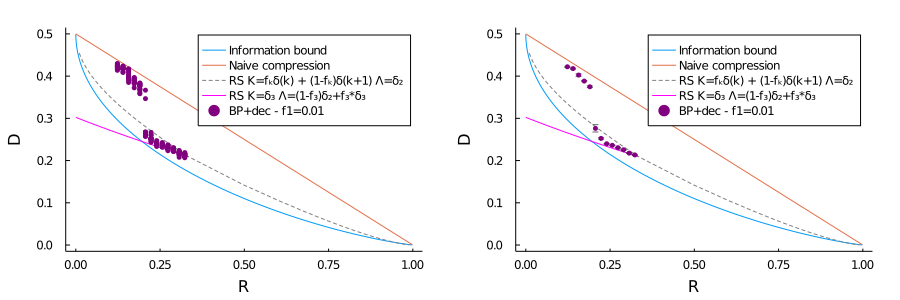

In [727]:
pl = plot_rdb(; f3=true)
for i in eachindex(R_bp)
    lab = i==1 ? "BP+dec - f1=$f1" : ""
    scatter!(pl, repeat([R_bp[i]], navg), D_bp[i], label=lab, ms=3, c=:purple)
end
pl2 = plot_rdb(; f3=true)
scatter!(pl2, R_bp, mean.(D_bp), label="BP+dec - f1=$f1", ms=3, c=:purple, yerr=std.(D_bp)/sqrt(navg), 
    grid=false, size=(400,400))
plot(pl, pl2, size=(900,300), margin=5Plots.mm)

In [735]:
using DelimitedFiles
open("bp_dec.txt", "w") do f   
   writedlm(f, [R_bp mean.(D_bp)])
end

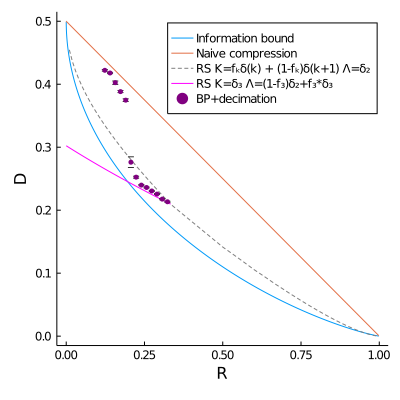

In [732]:
pl2 = plot_rdb(; f3=true)
scatter!(pl2, R_bp, mean.(D_bp), label="BP+decimation", ms=3, c=:purple, yerr=std.(D_bp)/sqrt(navg), 
    grid=false, size=(400,400))

In [733]:
savefig(pl2, "bp_dec.pdf")

### Unfair decimation

In [ ]:
f1 = 1/100
n = 1800
H = 3
f2s = [.35, .4, .45, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95]
navg = 15
D_bp_unfair = [zeros(navg) for f2 in f2s]
R_bp = zeros(length(f2s))
for i in eachindex(f2s)
    println("#### Rate $i of $(length(f2s))")
   @threads for j in 1:navg
        D_bp_unfair[i][j], bp, R_bp[i] = bp_dec(f1, f2s[i], n, H, Tmax=25, fair_decimation=false)
    end
    flush(stdout)
end

Trial 18 of 25: 296 unsat. Dist = 0.462
Trial 18 of 25: 340 unsat. Dist = 0.473
Trial 18 of 25: 340 unsat. Dist = 0.437
Trial 18 of 25: 319 unsat. Dist = 0.442
Trial 18 of 25: 349 unsat. Dist = 0.446
Trial 18 of 25: 338 unsat. Dist = 0.432
Trial 18 of 25: 350 unsat. Dist = 0.439
#### Rate 1 of 13
Trial 19 of 25: Trial 19 of 25: Trial 19 of 25: Trial 19 of 25: Trial 19 of 25: Trial 19 of 25: Trial 19 of 25: Trial 1 of 25: 339 unsat. Dist = 0.433
Trial 1 of 25: 337 unsat. Dist = 0.466
Trial 1 of 25: 388 unsat. Dist = 0.443
Trial 1 of 25: 355 unsat. Dist = 0.444
Trial 1 of 25: 364 unsat. Dist = 0.433
Trial 1 of 25: 297 unsat. Dist = 0.443
Trial 1 of 25: 352 unsat. Dist = 0.436
Trial 1 of 25: 338 unsat. Dist = 0.424
Trial 2 of 25: 375 unsat. Dist = 0.454
Trial 20 of 25: 409 unsat. Dist = 0.448
Trial 20 of 25: 362 unsat. Dist = 0.451
Trial 20 of 25: 354 unsat. Dist = 0.432
Trial 20 of 25: 351 unsat. Dist = 0.442
Trial 20 of 25: 367 unsat. Dist = 0.449
Trial 20 of 25: 380 unsat. Dist = 0.441

Trial 9 of 25: 355 unsat. Dist = 0.451
Trial 16 of 25: 356 unsat. Dist = 0.442
Trial 10 of 25: 418 unsat. Dist = 0.427
Trial 10 of 25: 359 unsat. Dist = 0.454
Trial 10 of 25: 383 unsat. Dist = 0.433
Trial 10 of 25: 426 unsat. Dist = 0.444
Trial 10 of 25: 372 unsat. Dist = 0.434
Trial 10 of 25: 340 unsat. Dist = 0.454
Trial 10 of 25: 370 unsat. Dist = 0.44
Trial 17 of 25: 354 unsat. Dist = 0.431
Trial 17 of 25: 310 unsat. Dist = 0.463
Trial 17 of 25: 247 unsat. Dist = 0.454
Trial 17 of 25: 368 unsat. Dist = 0.437
Trial 11 of 25: 412 unsat. Dist = 0.466
Trial 17 of 25: 327 unsat. Dist = 0.432
Trial 17 of 25: 388 unsat. Dist = 0.424
Trial 11 of 25: 386 unsat. Dist = 0.444
Trial 11 of 25: 375 unsat. Dist = 0.473
Trial 11 of 25: 361 unsat. Dist = 0.454
Trial 11 of 25: 352 unsat. Dist = 0.448
Trial 12 of 25: 384 unsat. Dist = 0.443
Trial 11 of 25: 377 unsat. Dist = 0.458
Trial 11 of 25: 373 unsat. Dist = 0.431
Trial 18 of 25: 364 unsat. Dist = 0.457
Trial 18 of 25: 335 unsat. Dist = 0.456
Tr

Trial 15 of 25: 328 unsat. Dist = 0.462
Trial 15 of 25: 377 unsat. Dist = 0.439
Trial 16 of 25: 338 unsat. Dist = 0.451
Trial 14 of 25: 364 unsat. Dist = 0.462
Trial 16 of 25: 365 unsat. Dist = 0.441
Trial 16 of 25: 345 unsat. Dist = 0.456
Trial 16 of 25: 380 unsat. Dist = 0.449
Trial 16 of 25: 337 unsat. Dist = 0.454
Trial 17 of 25: 388 unsat. Dist = 0.461
Trial 15 of 25: 448 unsat. Dist = 0.444
Trial 17 of 25: 387 unsat. Dist = 0.476
Trial 17 of 25: 359 unsat. Dist = 0.447
Trial 17 of 25: 365 unsat. Dist = 0.408
Trial 17 of 25: 416 unsat. Dist = 0.44
Trial 18 of 25: 353 unsat. Dist = 0.451
Trial 18 of 25: 332 unsat. Dist = 0.438
Trial 16 of 25: 340 unsat. Dist = 0.439
Trial 18 of 25: 407 unsat. Dist = 0.444
Trial 18 of 25: 363 unsat. Dist = 0.427
Trial 18 of 25: 392 unsat. Dist = 0.478
Trial 19 of 25: 353 unsat. Dist = 0.449
Trial 19 of 25: 357 unsat. Dist = 0.433
Trial 17 of 25: 393 unsat. Dist = 0.427
Trial 19 of 25: 345 unsat. Dist = 0.423
Trial 19 of 25: 362 unsat. Dist = 0.424
T

Trial 10 of 25: 340 unsat. Dist = 0.434
Trial 10 of 25: 357 unsat. Dist = 0.443
Trial 10 of 25: 356 unsat. Dist = 0.451
Trial 10 of 25: 359 unsat. Dist = 0.413
Trial 10 of 25: 311 unsat. Dist = 0.421
Trial 10 of 25: 358 unsat. Dist = 0.438
Trial 11 of 25: 331 unsat. Dist = 0.446
Trial 11 of 25: 306 unsat. Dist = 0.451
Trial 11 of 25: 355 unsat. Dist = 0.44
Trial 11 of 25: 354 unsat. Dist = 0.434
Trial 11 of 25: 294 unsat. Dist = 0.446
Trial 11 of 25: 358 unsat. Dist = 0.443
Trial 11 of 25: 291 unsat. Dist = 0.439
Trial 12 of 25: 325 unsat. Dist = 0.47
Trial 12 of 25: 375 unsat. Dist = 0.436
Trial 12 of 25: 319 unsat. Dist = 0.421
Trial 12 of 25: 325 unsat. Dist = 0.449
Trial 12 of 25: 324 unsat. Dist = 0.443
Trial 12 of 25: 333 unsat. Dist = 0.451
Trial 12 of 25: 317 unsat. Dist = 0.431
Trial 13 of 25: 311 unsat. Dist = 0.427
Trial 13 of 25: 299 unsat. Dist = 0.44
Trial 13 of 25: 339 unsat. Dist = 0.444
Trial 13 of 25: 320 unsat. Dist = 0.432
Trial 13 of 25: 320 unsat. Dist = 0.438
Tri

Trial 10 of 25: 325 unsat. Dist = 0.428
Trial 10 of 25: 316 unsat. Dist = 0.426
Trial 8 of 25: 275 unsat. Dist = 0.429
Trial 10 of 25: 298 unsat. Dist = 0.401
Trial 10 of 25: 262 unsat. Dist = 0.431
Trial 11 of 25: 321 unsat. Dist = 0.446
Trial 11 of 25: 277 unsat. Dist = 0.434
Trial 9 of 25: 305 unsat. Dist = 0.423
Trial 11 of 25: 282 unsat. Dist = 0.421
Trial 11 of 25: 270 unsat. Dist = 0.426
Trial 11 of 25: 279 unsat. Dist = 0.406
Trial 11 of 25: 322 unsat. Dist = 0.429
Trial 12 of 25: 308 unsat. Dist = 0.446
Trial 12 of 25: 331 unsat. Dist = 0.419
Trial 10 of 25: 300 unsat. Dist = 0.436
Trial 12 of 25: 338 unsat. Dist = 0.421
Trial 12 of 25: 303 unsat. Dist = 0.435
Trial 12 of 25: 311 unsat. Dist = 0.427
Trial 12 of 25: 292 unsat. Dist = 0.441
Trial 13 of 25: 255 unsat. Dist = 0.425
Trial 13 of 25: 293 unsat. Dist = 0.432
Trial 11 of 25: 258 unsat. Dist = 0.438
Trial 13 of 25: 311 unsat. Dist = 0.42
Trial 13 of 25: 313 unsat. Dist = 0.424
Trial 13 of 25: 313 unsat. Dist = 0.439
Tri

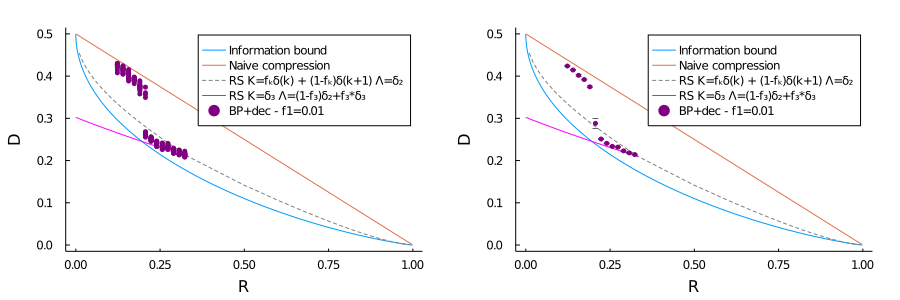

In [749]:
pl_unfair = plot_rdb(; f3=true)
for i in eachindex(R_bp)
    lab = i==1 ? "BP+dec - f1=$f1" : ""
    scatter!(pl_unfair, repeat([R_bp[i]], navg), D_bp_unfair[i], label=lab, ms=3, c=:purple)
end
pl2_unfair = plot_rdb(; f3=true)
scatter!(pl2_unfair, R_bp, mean.(D_bp_unfair), label="BP+dec - f1=$f1", ms=3, c=:purple, yerr=std.(D_bp_unfair)/sqrt(navg), 
    grid=false, size=(400,400))
plot(pl_unfair, pl2_unfair, size=(900,300), margin=5Plots.mm)

### 2.bis With zero leaves

In [736]:
f1 = 0.0
n = 1800
H = 3
f2s = [.35, .4, .45, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95]
navg = 15
D_bp2 = [zeros(navg) for f2 in f2s]
R_bp2 = zeros(length(f2s))
for i in eachindex(f2s)
    println("#### Rate $i of $(length(f2s))")
    @threads for j in 1:navg
        D_bp2[i][j], bp, R_bp2[i] = bp_dec(f1, f2s[i], n, H, Tmax=25)
    end
    flush(stdout)
end

#### Rate 1 of 13
Trial 1 of 25: 392 unsat. Dist = 0.451
Trial 1 of 25: 388 unsat. Dist = 0.469
Trial 1 of 25: 405 unsat. Dist = 0.432
Trial 1 of 25: 404 unsat. Dist = 0.457
Trial 1 of 25: 419 unsat. Dist = 0.435
Trial 1 of 25: 392 unsat. Dist = 0.452
Trial 1 of 25: 409 unsat. Dist = 0.446
Trial 1 of 25: 401 unsat. Dist = 0.444
Trial 2 of 25: 415 unsat. Dist = 0.453
Trial 2 of 25: 374 unsat. Dist = 0.459
Trial 2 of 25: 405 unsat. Dist = 0.459
Trial 2 of 25: 354 unsat. Dist = 0.446
Trial 2 of 25: 377 unsat. Dist = 0.448
Trial 2 of 25: 424 unsat. Dist = 0.444
Trial 2 of 25: 396 unsat. Dist = 0.481
Trial 2 of 25: 402 unsat. Dist = 0.455
Trial 3 of 25: 415 unsat. Dist = 0.433
Trial 3 of 25: 393 unsat. Dist = 0.443
Trial 3 of 25: 413 unsat. Dist = 0.456
Trial 3 of 25: 439 unsat. Dist = 0.459
Trial 3 of 25: 390 unsat. Dist = 0.441
Trial 3 of 25: 373 unsat. Dist = 0.443
Trial 3 of 25: 412 unsat. Dist = 0.449
Trial 3 of 25: 421 unsat. Dist = 0.47
Trial 4 of 25: 360 unsat. Dist = 0.468
Trial 4 

Trial 9 of 25: 367 unsat. Dist = 0.466
Trial 9 of 25: 458 unsat. Dist = 0.454
Trial 10 of 25: 393 unsat. Dist = 0.447
Trial 10 of 25: 377 unsat. Dist = 0.456
Trial 10 of 25: 368 unsat. Dist = 0.437
Trial 10 of 25: 370 unsat. Dist = 0.452
Trial 10 of 25: 368 unsat. Dist = 0.452
Trial 10 of 25: 367 unsat. Dist = 0.437
Trial 10 of 25: 400 unsat. Dist = 0.438
Trial 11 of 25: 385 unsat. Dist = 0.453
Trial 11 of 25: 381 unsat. Dist = 0.442
Trial 11 of 25: 370 unsat. Dist = 0.45
Trial 11 of 25: 397 unsat. Dist = 0.453
Trial 11 of 25: 355 unsat. Dist = 0.455
Trial 11 of 25: 371 unsat. Dist = 0.469
Trial 11 of 25: 424 unsat. Dist = 0.444
Trial 12 of 25: 386 unsat. Dist = 0.452
Trial 12 of 25: 403 unsat. Dist = 0.465
Trial 12 of 25: 413 unsat. Dist = 0.467
Trial 12 of 25: 340 unsat. Dist = 0.458
Trial 12 of 25: 418 unsat. Dist = 0.449
Trial 12 of 25: 411 unsat. Dist = 0.449
Trial 12 of 25: 406 unsat. Dist = 0.467
Trial 13 of 25: 406 unsat. Dist = 0.448
Trial 13 of 25: 400 unsat. Dist = 0.451
Tri

Trial 10 of 25: 348 unsat. Dist = 0.429
Trial 10 of 25: 336 unsat. Dist = 0.441
Trial 10 of 25: 306 unsat. Dist = 0.447
Trial 10 of 25: 296 unsat. Dist = 0.452
Trial 10 of 25: 405 unsat. Dist = 0.448
Trial 11 of 25: 377 unsat. Dist = 0.434
Trial 11 of 25: 361 unsat. Dist = 0.448
Trial 11 of 25: 356 unsat. Dist = 0.443
Trial 11 of 25: 373 unsat. Dist = 0.426
Trial 11 of 25: 368 unsat. Dist = 0.467
Trial 11 of 25: 318 unsat. Dist = 0.446
Trial 11 of 25: 341 unsat. Dist = 0.441
Trial 12 of 25: 357 unsat. Dist = 0.473
Trial 12 of 25: 360 unsat. Dist = 0.459
Trial 12 of 25: 362 unsat. Dist = 0.426
Trial 12 of 25: 332 unsat. Dist = 0.433
Trial 12 of 25: 383 unsat. Dist = 0.433
Trial 13 of 25: 336 unsat. Dist = 0.443
Trial 12 of 25: 326 unsat. Dist = 0.446
Trial 12 of 25: 389 unsat. Dist = 0.444
Trial 13 of 25: 377 unsat. Dist = 0.463
Trial 13 of 25: 359 unsat. Dist = 0.433
Trial 13 of 25: 278 unsat. Dist = 0.448
Trial 13 of 25: 315 unsat. Dist = 0.453
Trial 14 of 25: 359 unsat. Dist = 0.456


Trial 9 of 25: 355 unsat. Dist = 0.429
Trial 9 of 25: 332 unsat. Dist = 0.423
Trial 10 of 25: 330 unsat. Dist = 0.422
Trial 10 of 25: 287 unsat. Dist = 0.412
Trial 10 of 25: 279 unsat. Dist = 0.42
Trial 8 of 25: 354 unsat. Dist = 0.401
Trial 10 of 25: 304 unsat. Dist = 0.426
Trial 10 of 25: 368 unsat. Dist = 0.423
Trial 10 of 25: 320 unsat. Dist = 0.434
Trial 11 of 25: 310 unsat. Dist = 0.418
Trial 11 of 25: 306 unsat. Dist = 0.449
Trial 11 of 25: 261 unsat. Dist = 0.423
Trial 9 of 25: 343 unsat. Dist = 0.433
Trial 11 of 25: 322 unsat. Dist = 0.402
Trial 11 of 25: 346 unsat. Dist = 0.442
Trial 11 of 25: 320 unsat. Dist = 0.429
Trial 12 of 25: 297 unsat. Dist = 0.432
Trial 12 of 25: 308 unsat. Dist = 0.427
Trial 12 of 25: 305 unsat. Dist = 0.433
Trial 10 of 25: 287 unsat. Dist = 0.412
Trial 12 of 25: 297 unsat. Dist = 0.442
Trial 12 of 25: 352 unsat. Dist = 0.435
Trial 12 of 25: 358 unsat. Dist = 0.437
Trial 13 of 25: 301 unsat. Dist = 0.425
Trial 13 of 25: 326 unsat. Dist = 0.438
Trial

Trial 10 of 25: 271 unsat. Dist = 0.429
Trial 10 of 25: 240 unsat. Dist = 0.427
Trial 10 of 25: 236 unsat. Dist = 0.406
Trial 10 of 25: 234 unsat. Dist = 0.437
Trial 10 of 25: 261 unsat. Dist = 0.399
Trial 11 of 25: 250 unsat. Dist = 0.415
Trial 11 of 25: 231 unsat. Dist = 0.408
Trial 11 of 25: 292 unsat. Dist = 0.404
Trial 11 of 25: 226 unsat. Dist = 0.416
Trial 11 of 25: 298 unsat. Dist = 0.434
Trial 11 of 25: 262 unsat. Dist = 0.393
Trial 11 of 25: 210 unsat. Dist = 0.394
Trial 12 of 25: 291 unsat. Dist = 0.428
Trial 12 of 25: 282 unsat. Dist = 0.423
Trial 12 of 25: 293 unsat. Dist = 0.416
Trial 12 of 25: 272 unsat. Dist = 0.429
Trial 12 of 25: 253 unsat. Dist = 0.408
Trial 13 of 25: 243 unsat. Dist = 0.402
Trial 12 of 25: 233 unsat. Dist = 0.382
Trial 12 of 25: 223 unsat. Dist = 0.428
Trial 13 of 25: 249 unsat. Dist = 0.408
Trial 13 of 25: 256 unsat. Dist = 0.399
Trial 13 of 25: 290 unsat. Dist = 0.416
Trial 13 of 25: 270 unsat. Dist = 0.411
Trial 14 of 25: 316 unsat. Dist = 0.416


Trial 9 of 25: 226 unsat. Dist = 0.363
Trial 9 of 25: 188 unsat. Dist = 0.409
Trial 9 of 25: 199 unsat. Dist = 0.431
Trial 9 of 25: 211 unsat. Dist = 0.394
Trial 10 of 25: 189 unsat. Dist = 0.395
Trial 10 of 25: 177 unsat. Dist = 0.415
Trial 10 of 25: 177 unsat. Dist = 0.384
Trial 10 of 25: 210 unsat. Dist = 0.391
Trial 10 of 25: 203 unsat. Dist = 0.388
Trial 10 of 25: 275 unsat. Dist = 0.411
Trial 10 of 25: 227 unsat. Dist = 0.413
Trial 11 of 25: 214 unsat. Dist = 0.416
Trial 11 of 25: 225 unsat. Dist = 0.4
Trial 11 of 25: 244 unsat. Dist = 0.394
Trial 11 of 25: 191 unsat. Dist = 0.392
Trial 11 of 25: 214 unsat. Dist = 0.397
Trial 11 of 25: 187 unsat. Dist = 0.397
Trial 12 of 25: 191 unsat. Dist = 0.398
Trial 12 of 25: 201 unsat. Dist = 0.379
Trial 12 of 25: 191 unsat. Dist = 0.412
Trial 11 of 25: 217 unsat. Dist = 0.401
Trial 12 of 25: 224 unsat. Dist = 0.404
Trial 12 of 25: 214 unsat. Dist = 0.418
Trial 12 of 25: 200 unsat. Dist = 0.394
Trial 13 of 25: 177 unsat. Dist = 0.397
Trial 

Trial 11 of 25: 0 unsat. Dist = 0.489
Trial 11 of 25: 194 unsat. Dist = 0.379
Trial 10 of 25: 173 unsat. Dist = 0.403
Trial 10 of 25: 0 unsat. Dist = 0.515
Trial 10 of 25: 0 unsat. Dist = 0.492
Trial 10 of 25: 0 unsat. Dist = 0.507
Trial 11 of 25: 0 unsat. Dist = 0.515
Trial 12 of 25: 0 unsat. Dist = 0.514
Trial 12 of 25: 0 unsat. Dist = 0.489
Trial 11 of 25: 181 unsat. Dist = 0.37
Trial 11 of 25: 214 unsat. Dist = 0.392
Trial 11 of 25: 182 unsat. Dist = 0.391
Trial 11 of 25: 0 unsat. Dist = 0.507
Trial 12 of 25: 170 unsat. Dist = 0.389
Trial 13 of 25: 0 unsat. Dist = 0.514
Trial 13 of 25: 202 unsat. Dist = 0.413
Trial 12 of 25: 0 unsat. Dist = 0.513
Trial 12 of 25: 163 unsat. Dist = 0.401
Trial 12 of 25: 147 unsat. Dist = 0.407
Trial 12 of 25: 142 unsat. Dist = 0.404
Trial 13 of 25: 228 unsat. Dist = 0.398
Trial 14 of 25: 0 unsat. Dist = 0.514
Trial 14 of 25: 177 unsat. Dist = 0.392
Trial 13 of 25: 185 unsat. Dist = 0.404
Trial 13 of 25: 0 unsat. Dist = 0.515
Trial 13 of 25: 187 unsat

Trial 13 of 25: 0 unsat. Dist = 0.501
Trial 11 of 25: 0 unsat. Dist = 0.499
Trial 11 of 25: 3 unsat. Dist = 0.353
Trial 12 of 25: 0 unsat. Dist = 0.526
Trial 12 of 25: 0 unsat. Dist = 0.508
Trial 12 of 25: 0 unsat. Dist = 0.511
Trial 13 of 25: 0 unsat. Dist = 0.487
Trial 14 of 25: 0 unsat. Dist = 0.501
Trial 12 of 25: 0 unsat. Dist = 0.256
Trial 12 of 25: 0 unsat. Dist = 0.503
Trial 13 of 25: 0 unsat. Dist = 0.526
Trial 14 of 25: 0 unsat. Dist = 0.254
Trial 13 of 25: 0 unsat. Dist = 0.511
Trial 13 of 25: 0 unsat. Dist = 0.508
Trial 15 of 25: 0 unsat. Dist = 0.501
Trial 13 of 25: 0 unsat. Dist = 0.499
Trial 13 of 25: 0 unsat. Dist = 0.503
Trial 14 of 25: 56 unsat. Dist = 0.367
Trial 15 of 25: 0 unsat. Dist = 0.487
Trial 14 of 25: 0 unsat. Dist = 0.511
Trial 14 of 25: 0 unsat. Dist = 0.508
Trial 16 of 25: 0 unsat. Dist = 0.501
Trial 14 of 25: 0 unsat. Dist = 0.499
Trial 14 of 25: 0 unsat. Dist = 0.503
Trial 15 of 25: 123 unsat. Dist = 0.354
Trial 15 of 25: 0 unsat. Dist = 0.256
Trial 16 

Trial 12 of 25: 0 unsat. Dist = 0.482
Trial 12 of 25: 2 unsat. Dist = 0.252
Trial 11 of 25: 0 unsat. Dist = 0.503
Trial 12 of 25: 0 unsat. Dist = 0.247
Trial 13 of 25: 0 unsat. Dist = 0.496
Trial 12 of 25: 0 unsat. Dist = 0.475
Trial 12 of 25: 0 unsat. Dist = 0.508
Trial 13 of 25: 1 unsat. Dist = 0.319
Trial 13 of 25: 1 unsat. Dist = 0.309
Trial 12 of 25: 0 unsat. Dist = 0.503
Trial 13 of 25: 0 unsat. Dist = 0.491
Trial 14 of 25: 0 unsat. Dist = 0.251
Trial 13 of 25: 0 unsat. Dist = 0.508
Trial 13 of 25: 0 unsat. Dist = 0.475
Trial 14 of 25: 1 unsat. Dist = 0.325
Trial 14 of 25: 1 unsat. Dist = 0.317
Trial 13 of 25: 10 unsat. Dist = 0.326
Trial 14 of 25: 0 unsat. Dist = 0.475
Trial 14 of 25: 0 unsat. Dist = 0.491
Trial 15 of 25: 0 unsat. Dist = 0.496
Trial 14 of 25: 1 unsat. Dist = 0.312
Trial 15 of 25: 0 unsat. Dist = 0.482
Trial 15 of 25: 0 unsat. Dist = 0.253
Trial 14 of 25: 0 unsat. Dist = 0.503
Trial 15 of 25: 0 unsat. Dist = 0.246
Trial 15 of 25: 0 unsat. Dist = 0.491
Trial 16 of

Trial 12 of 25: 1 unsat. Dist = 0.283
Trial 12 of 25: 0 unsat. Dist = 0.251
Trial 13 of 25: 0 unsat. Dist = 0.487
Trial 13 of 25: 1 unsat. Dist = 0.258
Trial 12 of 25: 1 unsat. Dist = 0.265
Trial 12 of 25: 0 unsat. Dist = 0.238
Trial 13 of 25: 1 unsat. Dist = 0.27
Trial 12 of 25: 0 unsat. Dist = 0.513
Trial 13 of 25: 0 unsat. Dist = 0.237
Trial 14 of 25: 1 unsat. Dist = 0.258
Trial 14 of 25: 2 unsat. Dist = 0.261
Trial 13 of 25: 0 unsat. Dist = 0.244
Trial 13 of 25: 0 unsat. Dist = 0.242
Trial 14 of 25: 1 unsat. Dist = 0.265
Trial 13 of 25: 2 unsat. Dist = 0.25
Trial 14 of 25: 0 unsat. Dist = 0.239
Trial 15 of 25: 0 unsat. Dist = 0.494
Trial 15 of 25: 0 unsat. Dist = 0.487
Trial 14 of 25: 1 unsat. Dist = 0.256
Trial 14 of 25: 0 unsat. Dist = 0.508
Trial 15 of 25: 1 unsat. Dist = 0.268
Trial 15 of 25: 0 unsat. Dist = 0.237
Trial 14 of 25: 0 unsat. Dist = 0.513
Trial 16 of 25: 1 unsat. Dist = 0.264
Trial 16 of 25: 0 unsat. Dist = 0.241
Trial 15 of 25: 0 unsat. Dist = 0.238
Trial 15 of 25

Trial 11 of 25: 0 unsat. Dist = 0.476
Trial 10 of 25: 0 unsat. Dist = 0.506
Trial 11 of 25: 0 unsat. Dist = 0.232
Trial 11 of 25: 0 unsat. Dist = 0.234
Trial 11 of 25: 0 unsat. Dist = 0.238
Trial 11 of 25: 0 unsat. Dist = 0.503
Trial 14 of 25: 3 unsat. Dist = 0.256
Trial 12 of 25: 0 unsat. Dist = 0.476
Trial 11 of 25: 0 unsat. Dist = 0.506
Trial 12 of 25: 0 unsat. Dist = 0.233
Trial 12 of 25: 1 unsat. Dist = 0.272
Trial 12 of 25: 0 unsat. Dist = 0.235
Trial 12 of 25: 1 unsat. Dist = 0.254
Trial 15 of 25: 0 unsat. Dist = 0.497
Trial 13 of 25: 0 unsat. Dist = 0.476
Trial 12 of 25: 0 unsat. Dist = 0.506
Trial 13 of 25: 0 unsat. Dist = 0.501
Trial 13 of 25: 0 unsat. Dist = 0.49
Trial 13 of 25: 0 unsat. Dist = 0.228
Trial 13 of 25: 0 unsat. Dist = 0.238
Trial 16 of 25: 0 unsat. Dist = 0.23
Trial 14 of 25: 0 unsat. Dist = 0.476
Trial 13 of 25: 0 unsat. Dist = 0.506
Trial 14 of 25: 1 unsat. Dist = 0.271
Trial 14 of 25: 0 unsat. Dist = 0.237
Trial 14 of 25: 2 unsat. Dist = 0.271
Trial 14 of 25

Trial 8 of 25: 7 unsat. Dist = 0.268
Trial 8 of 25: 0 unsat. Dist = 0.234
Trial 9 of 25: 0 unsat. Dist = 0.232
Trial 8 of 25: 1 unsat. Dist = 0.279
Trial 12 of 25: 2 unsat. Dist = 0.245
Trial 9 of 25: 2 unsat. Dist = 0.228
Trial 8 of 25: 0 unsat. Dist = 0.466
Trial 9 of 25: 1 unsat. Dist = 0.288
Trial 10 of 25: 1 unsat. Dist = 0.279
Trial 13 of 25: 1 unsat. Dist = 0.245
Trial 9 of 25: 0 unsat. Dist = 0.499
Trial 14 of 25: 1 unsat. Dist = 0.246
Trial 10 of 25: 1 unsat. Dist = 0.299
Trial 9 of 25: 1 unsat. Dist = 0.278
Trial 10 of 25: 0 unsat. Dist = 0.242
Trial 11 of 25: 0 unsat. Dist = 0.515
Trial 10 of 25: 0 unsat. Dist = 0.499
Trial 10 of 25: 0 unsat. Dist = 0.227
Trial 15 of 25: 0 unsat. Dist = 0.5
Trial 11 of 25: 0 unsat. Dist = 0.53
Trial 11 of 25: 0 unsat. Dist = 0.489
Trial 16 of 25: 0 unsat. Dist = 0.5
Trial 12 of 25: 0 unsat. Dist = 0.233
Trial 11 of 25: 0 unsat. Dist = 0.499
Trial 11 of 25: 3 unsat. Dist = 0.278
Trial 12 of 25: 0 unsat. Dist = 0.53
Trial 12 of 25: 0 unsat. Di

Trial 11 of 25: 0 unsat. Dist = 0.226
Trial 1 of 25: 0 unsat. Dist = 0.22
Trial 7 of 25: 1 unsat. Dist = 0.247
Trial 2 of 25: 0 unsat. Dist = 0.497
Trial 8 of 25: 1 unsat. Dist = 0.247
Trial 19 of 25: 1 unsat. Dist = 0.231
Trial 16 of 25: 0 unsat. Dist = 0.495
Trial 9 of 25: 0 unsat. Dist = 0.234
Trial 12 of 25: 0 unsat. Dist = 0.227
Trial 2 of 25: 0 unsat. Dist = 0.232
Trial 3 of 25: 1 unsat. Dist = 0.25
Trial 10 of 25: 0 unsat. Dist = 0.224
Trial 20 of 25: 1 unsat. Dist = 0.231
Trial 11 of 25: 1 unsat. Dist = 0.249
Trial 17 of 25: 2 unsat. Dist = 0.253
Trial 13 of 25: 0 unsat. Dist = 0.513
Trial 3 of 25: 15 unsat. Dist = 0.233
Trial 4 of 25: 4 unsat. Dist = 0.264
Trial 12 of 25: 0 unsat. Dist = 0.227
Trial 21 of 25: 1 unsat. Dist = 0.231
Trial 13 of 25: 1 unsat. Dist = 0.247
Trial 18 of 25: 1 unsat. Dist = 0.252
Trial 5 of 25: 1 unsat. Dist = 0.253
Trial 14 of 25: 0 unsat. Dist = 0.513
Trial 4 of 25: 1 unsat. Dist = 0.243
Trial 14 of 25: 0 unsat. Dist = 0.506
Trial 22 of 25: 1 unsat.

Trial 18 of 25: 0 unsat. Dist = 0.214
Trial 22 of 25: 0 unsat. Dist = 0.224
Trial 25 of 25: 0 unsat. Dist = 0.221
Trial 12 of 25: 0 unsat. Dist = 0.216
Trial 23 of 25: 1 unsat. Dist = 0.228
Trial 17 of 25: 0 unsat. Dist = 0.223
Trial 20 of 25: 0 unsat. Dist = 0.511
Trial 13 of 25: 3 unsat. Dist = 0.238
Trial 16 of 25: 0 unsat. Dist = 0.234
Trial 19 of 25: 0 unsat. Dist = 0.212
Trial 14 of 25: 1 unsat. Dist = 0.239
Trial 24 of 25: 0 unsat. Dist = 0.215
Trial 18 of 25: 0 unsat. Dist = 0.216
Trial 20 of 25: 1 unsat. Dist = 0.227
Trial 15 of 25: 0 unsat. Dist = 0.216
Trial 21 of 25: 0 unsat. Dist = 0.229
Trial 25 of 25: 1 unsat. Dist = 0.234
Trial 17 of 25: 4 unsat. Dist = 0.236
Trial 16 of 25: 0 unsat. Dist = 0.217
Trial 19 of 25: 0 unsat. Dist = 0.214
Trial 21 of 25: 1 unsat. Dist = 0.23
Trial 17 of 25: 0 unsat. Dist = 0.217
Trial 22 of 25: 0 unsat. Dist = 0.209
Trial 22 of 25: 0 unsat. Dist = 0.224
Trial 18 of 25: 1 unsat. Dist = 0.231
Trial 20 of 25: 1 unsat. Dist = 0.232
Trial 18 of 2

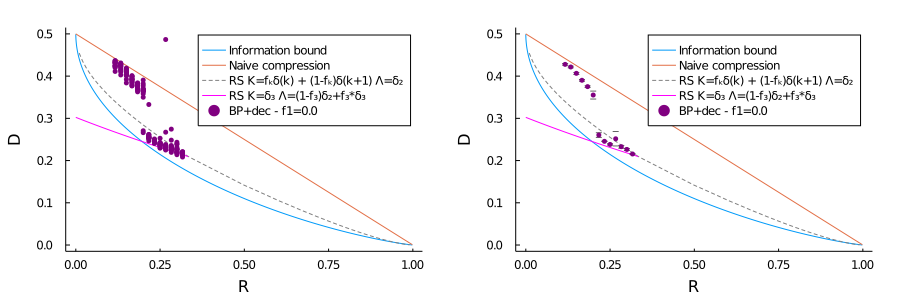

In [741]:
pl3 = plot_rdb(; f3=true)
for i in eachindex(R_bp)
    lab = i==1 ? "BP+dec - f1=$f1" : ""
    scatter!(pl3, repeat([R_bp2[i]], navg), D_bp2[i], label=lab, ms=3, c=:purple)
end
pl4 = plot_rdb(; f3=true)
scatter!(pl4, R_bp2, mean.(D_bp2), label="BP+dec - f1=$f1", ms=3, c=:purple, yerr=std.(D_bp2)/sqrt(navg), 
    grid=false, size=(400,400))
plot(pl3, pl4, size=(900,300), margin=5Plots.mm)

In [738]:
savefig(pl2, "bp_dec_zeroleaves.pdf")

In [746]:
using DelimitedFiles
open("bp_dec_zeroleaves.txt", "w") do f   
   writedlm(f, [R_bp2 mean.(D_bp2)])
end

## 3. MS + reinforcement

In [697]:
function ms_rein(f1, f2, n; Tmax=1, maxiter=10^3, rein=1e-4)
    f3 = 1 - f1 -f2
    Lambda = [f1,f2,f3]
    K = [0,0,1]
    nedges = Int(round(n*sum(i*l for (i,l) in pairs(Lambda)), digits=10))
    m = Int(nedges/3)
    ds = zeros(Tmax); nunsats = zeros(Int, Tmax)
    R = 0.0
    for t in 1:Tmax
        s = rand((-1,1), n)
        efield = [float.((ss,-ss)) for ss in s]
        ms = bp_full(n, m, nedges, Lambda, K, efield)
        B, indep = findbasis_slow(Array(ms.H))
        R = size(B,2)/n
        ε, iters = iteration_ms!(ms, maxiter=maxiter, rein=rein)
        nunsats[t], ovl, ds[t] = performance(ms, s)
        if nunsats[t]!=0
            x = argmax.(ms.belief) .== 2
            σ = fix_indep!(x, B, indep) 
            @assert parity(ms.H, x)==0
            ds[t] = distortion(σ,s)
        end
    end
    minimum(ds), ds[argmin(nunsats)], R
end

ms_rein (generic function with 2 methods)

In [698]:
f1 = 1/100
n = 1800
f2s = [.35, .4, .45, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95]
navg = 15
D_ms = [fill(NaN, navg) for f2 in f2s]
D_ms2 = [fill(NaN, navg) for f2 in f2s]
R_ms = zeros(length(f2s))

for i in eachindex(f2s)
    println("#### Rate $i of $(length(f2s))")
   @threads for j in 1:navg
        D_ms[i][j], D_ms2[i][j], R_ms[i] = ms_rein(f1, f2s[i], n, Tmax=100, maxiter=5*10^3, rein=1e-4)
    end
    flush(stdout)
end

#### Rate 1 of 13
#### Rate 2 of 13
#### Rate 3 of 13
#### Rate 4 of 13
#### Rate 5 of 13
#### Rate 6 of 13
#### Rate 7 of 13
#### Rate 8 of 13
#### Rate 9 of 13
#### Rate 10 of 13
#### Rate 11 of 13
#### Rate 12 of 13
#### Rate 13 of 13


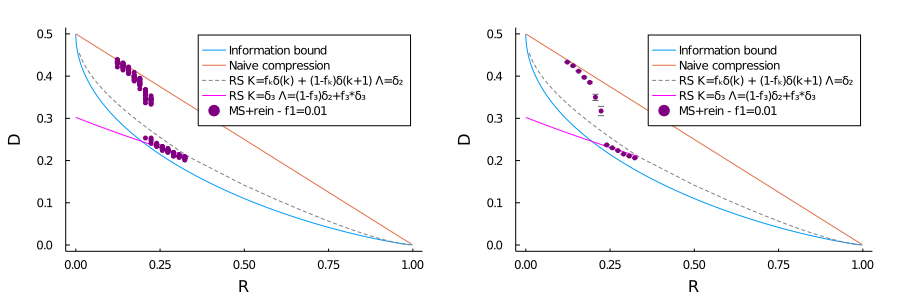

In [700]:
pl_ms = plot_rdb(; f3=true)
for i in eachindex(R_ms)
    lab = i==1 ? "MS+rein - f1=$f1" : ""
    scatter!(pl_ms, repeat([R_ms[i]], navg), D_ms[i], label=lab, ms=3, c=:purple)
end
pl_ms
pl_ms2 = plot_rdb(; f3=true)
scatter!(pl_ms2, R_ms, mean.(D_ms), label="MS+rein - f1=$f1", ms=3, c=:purple, yerr=std.(D_ms)/sqrt(navg))
plot(pl_ms, pl_ms2, size=(900,300), margin=5Plots.mm)

## 4. Effect of leaves

In [754]:
include("../code/bp_full.jl")
include("../code/optimal_cycle.jl")
include("../code/rs.jl")
include("../code/bp.jl")

cb_decimation (generic function with 2 methods)

In [757]:
function buildgraph(R, f1, f3; tol=1e-2, B=0) 
    f2 = 1.0-f1-f3
    α = 1-R
    k = floor(Int, (2-f1+f3)/α)
    s = k+1-(2-f1+f3)/α
    K = [fill(0,k-1); s; 1-s]
    Λ = [f1, f2, f3]
    m, n, nedges, rho, lambda = valid_degrees(K,Λ,3*5*7, B=1)
    if B==0
        B = 10^max(0, 3-round(Int,log10(n)))
    end
    m, n, nedges, rho, lambda = valid_degrees(K,Λ,3*5*7, B=B)
    @assert isapprox(Λ, lambda, atol=tol)
    @assert isapprox(lambda[1], f1, atol=tol)
    @assert isapprox(R, rate(lambda, rho), atol=tol)
    m, n, nedges, rho, lambda
end

function bp_dec(n, m, nedges, rho, lambda, β; Tmax=1, fair_decimation=true,
        verbose=true)
    s = rand((-1,1), n)
    efield = [(exp(β*ss),exp(-β*ss)) for ss in s]
    bp = bp_full(n, m, nedges, lambda, rho, efield)
    B, indep = findbasis_slow(Array(bp.H))
    R = size(B,2)/n
    dist = decimate!(bp, efield, indep, s, B, maxiter=10^3, Tmax=Tmax, tol=1e-5, 
        fair_decimation=fair_decimation, verbose=verbose) 
    dist, bp, R
end

bp_dec (generic function with 2 methods)

In [760]:
R = 0.5
f3 = 0.2
f1s = [0, 0.01, 0.02, 0.03]
Bs = [200, 10, 10, 30]

for (i,f1) in enumerate(f1s)
    m, n, nedges, rho, lambda = buildgraph(R, f1, f3, B=Bs[i])
    @show f1, n
end

(f1, n) = (0.0, 2000)
(f1, n) = (0.01, 2100)
(f1, n) = (0.02, 2100)
(f1, n) = (0.03, 2100)


In [ ]:
β = 3.0
navg = 10
Tmax = 20
D_bp = [zeros(navg) for _ in f1s]
R_bp = zeros(length(f1s))

for i in eachindex(f1s)
    prog = Progress(length(f1s))
    println("Degree profile $i of ", length(f1s))
    m, n, nedges, rho, lambda = buildgraph(R, f1s[i], f3)
    @threads for j in 1:navg
        D_bp[i][j], _, R_bp[i] = bp_dec(n, m, nedges, rho, lambda, β; Tmax=Tmax)
        next!(prog, showvalues=[(:i,i)])
    end 
end

Trial 17 of 20: 5 unsat. Dist = 0.17
Trial 16 of 20: 0 unsat. Dist = 0.505
Trial 17 of 20: 1 unsat. Dist = 0.152
Trial 20 of 20: 0 unsat. Dist = 0.14
Trial 16 of 20: 0 unsat. Dist = 0.154
Trial 16 of 20: 0 unsat. Dist = 0.504
Trial 17 of 20: 1 unsat. Dist = 0.163
Trial 18 of 20: 0 unsat. Dist = 0.144
Trial 18 of 20: 0 unsat. Dist = 0.488
Trial 17 of 20: 0 unsat. Dist = 0.497
Trial 4 of 20: 0 unsat. Dist = 0.479
Trial 17 of 20: 0 unsat. Dist = 0.141
Trial 18 of 20: 0 unsat. Dist = 0.157
Trial 19 of 20: 0 unsat. Dist = 0.519
Trial 19 of 20: 0 unsat. Dist = 0.488
Trial 18 of 20: 0 unsat. Dist = 0.497
Trial 5 of 20: 1 unsat. Dist = 0.161


┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /home/crotti/.julia/packages/ProgressMeter/Vf8un/src/ProgressMeter.jl:620
Progress:  75%|██████████████████████████████▊          |  ETA: 0:03:47
  i:  1

In [769]:
pl = plot_rdb()
for i in eachindex(f1s)
    lab = "BP+dec - f1=$(f1s[i])"
    scatter!(pl, repeat([R_bp[i]], navg), D_bp[i], label=lab, ms=3)
end
pl2 = plot_rdb()
for i in eachindex(f1s)
    lab = "BP+dec - f1=$(f1s[i])"
    scatter!(pl2, [R_bp[i]], [mean(D_bp[i])], label=lab, ms=3)
end
pl3 = plot(pl, pl2, size=(900,300), margin=5Plots.mm)
savefig(pl3, "bp_dec_leaves.pdf")

In [ ]:
include("../../telegram/notifications.jl")
send_notif("BP leaves finished")

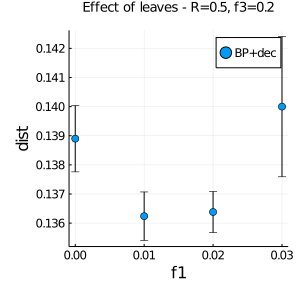

In [785]:
pp = scatter(f1s, mean.(D_bp), xlabel="f1", ylabel="dist", size=(300,300), yerr=std.(D_bp)/sqrt(navg),
    title="Effect of leaves - R=$(R_bp[1]), f3=$f3", titlefontsize=9, label="BP+dec")

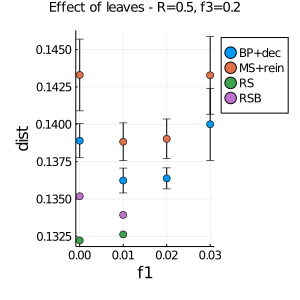

In [786]:
D_ms_avg = [0.14330199999999993, 0.13883238095238093, 0.1390261904761905, 0.1432771428571428]
D_ms_std = [0.007592789108519108, 0.003988755733787555, 0.004205302881770762, 0.008226726817889177]
f1_cavity = [0, 0.01]
D_rs = [0.13222941966534785, 0.13263241498621114]
D_rsb = [0.13518599886812038, 0.13393634019828132]
scatter!(pp, f1s, D_ms_avg, xlabel="f1", ylabel="dist", size=(300,300), yerr=D_ms_std/sqrt(navg),
    title="Effect of leaves - R=$(R_bp[1]), f3=$f3", titlefontsize=9, label="MS+rein")
scatter!(pp, f1_cavity, D_rs, label="RS")
scatter!(pp, f1_cavity, D_rsb, label="RSB", legend=:outertopright)